In [1]:
"""
Author: GJ Both
Date: 12/11/2024
In this notebook we check if the gradients are correct.
"""


'\nAuthor: GJ Both\nDate: 12/11/2024\nIn this notebook we check if the gradients are correct.\n'

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import Array
from samples import bio_cylinders
from solvers import Sample, thick_sample_exact
from jax.test_util import check_grads
import chromatix.functional as cf


In [10]:
# making source and sample
def generate_data(sample: Sample, implicit) -> Array:
    field = cf.plane_wave(
        (sample.shape[1], sample.shape[2]),
        sample.spacing * 4,
        spectrum=2.0,
        amplitude=jnp.array([0, 1, 1]),
    )
    field, results = thick_sample_exact(
        field,
        sample,
        boundary_width=(125, None, 125),
        rtol=1e-3,
        max_steps=100,
        implicit=implicit
    )
    return field.intensity.squeeze(), results



In [11]:
sample = bio_cylinders()
sample = sample.replace(permittivity=sample.permittivity[::4, :, ::4], spacing=sample.spacing * 4)
measurements, results = generate_data(sample, implicit=True)

def loss_fn(refractive_index, implicit):
    sample = Sample.init(refractive_index, spacing=0.1)
    images, _ = generate_data(sample, implicit)
    return jnp.mean(jnp.abs(images - measurements))

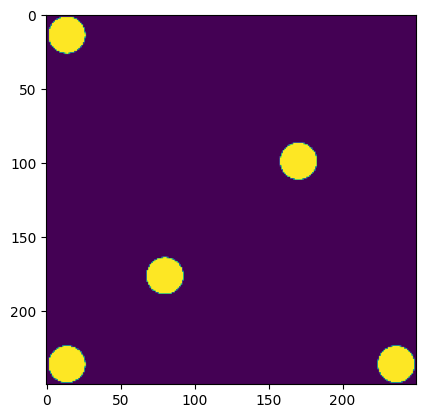

In [12]:
plt.imshow(sample.permittivity[:, 0, :])

In [13]:
results.n_steps

Array(96, dtype=int32, weak_type=True)

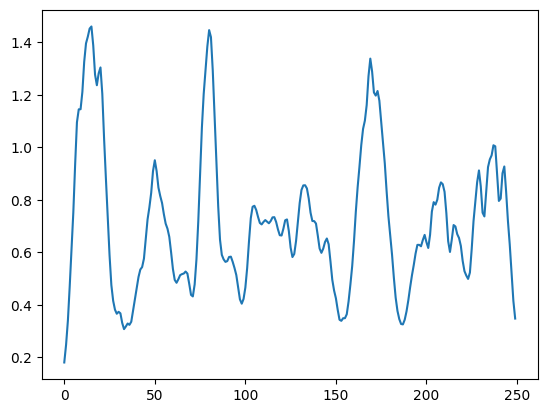

In [14]:
plt.plot(measurements)

In [15]:
# We can calculate grads!
n_sample = jnp.full(sample.shape, 1.33)
grads_imp = jax.jit(jax.grad(loss_fn), static_argnames="implicit")(n_sample, implicit=True)

In [16]:
# We can calculate grads!
grads_exp = jax.jit(jax.grad(loss_fn), static_argnames="implicit")(n_sample, implicit=False)

In [17]:
jnp.allclose(grads_imp, grads_exp)

Array(False, dtype=bool)

In [24]:
rel_error = jnp.abs((grads_imp - grads_exp) / (grads_imp + grads_exp))
rms_error = jnp.sqrt(jnp.mean((grads_exp-grads_imp)**2))

In [33]:
print(f"RMS error: {rms_error}")
print(f"Average norm of grads: {jnp.sqrt(jnp.mean(grads_exp**2))}")

RMS error: 2.6064697067340603e-06
Average norm of grads: 0.015499009750783443


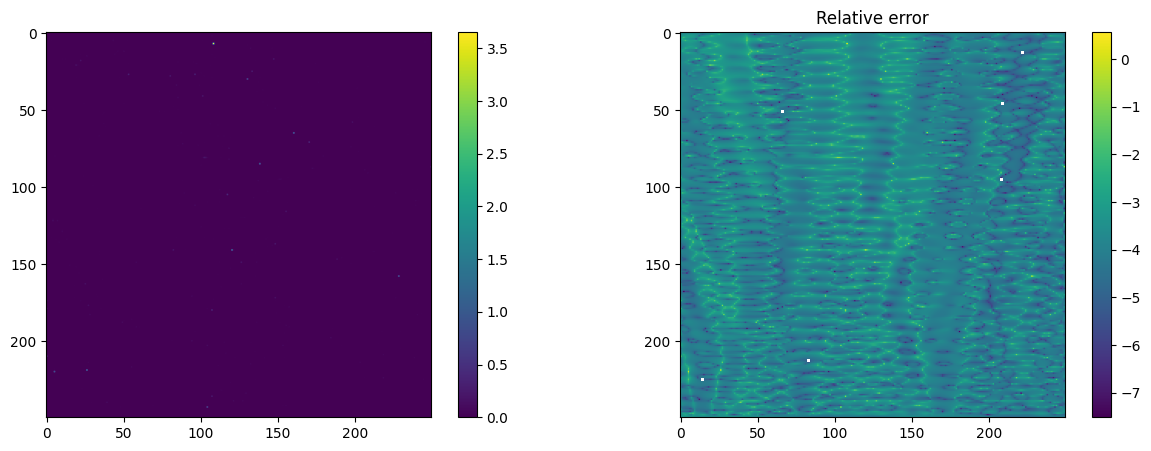

In [37]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.imshow(rel_error[:, 0, :])
plt.colorbar()


plt.subplot(122)
plt.imshow(jnp.log10(rel_error[:, 0, :]))
plt.title("Relative error")
plt.colorbar()

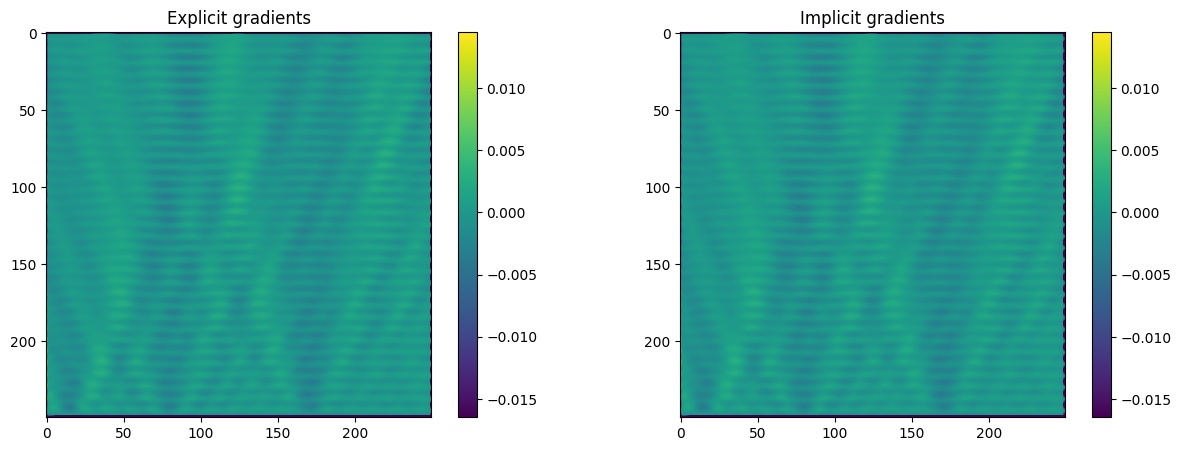

: 

In [48]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.title("Explicit gradients")
plt.imshow(grads_exp[:, 0, :], vmin=jnp.mean(grads_exp) - jnp.std(grads_exp), vmax=jnp.mean(grads_exp) + jnp.std(grads_exp))
plt.colorbar()

plt.subplot(122)
plt.title("Implicit gradients")
plt.imshow(grads_imp[:, 0, :], vmin=jnp.mean(grads_imp) - jnp.std(grads_imp), vmax=jnp.mean(grads_imp) + jnp.std(grads_imp))
plt.colorbar()